In [1]:
from plotting import plot_setup_platecarree, plot_setup_orthographic
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from os.path import join

data_folder = '~/data' # this is where the data files are saved
sst = xr.open_dataarray(join(data_folder,'sst_may2021.nc'))
uv10= xr.open_dataset(join(data_folder, 'uv10m_2021-05.nc'))
sp  = xr.open_dataarray(join(data_folder, 'sp_2021-05.nc'))/100 # convert to hPa

# Plot SST with different projections

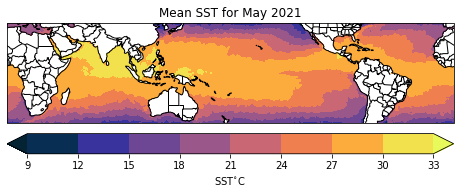

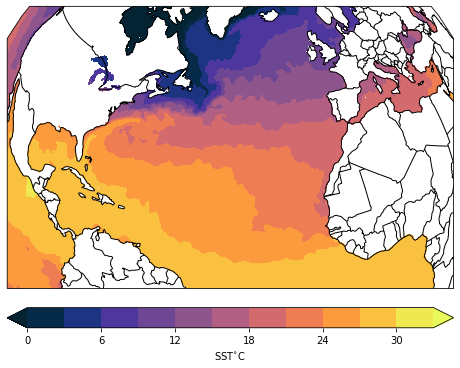

In [2]:
# Plot of global SST using PlateCarree projection
fig,ax = plot_setup_platecarree(plot_range=[0,359,-40,40], 
                                central_lon=180,figsize=(8,4))
cp     = ax.contourf(sst.lon, sst.lat, sst.mean('time'), 
                     cmap='cmo.thermal', levels=np.arange(9,36,3), extend='both', 
                     transform=ccrs.PlateCarree())
cb     = fig.colorbar(cp, orientation='horizontal', label=r'SST$^{\circ}$C',pad=.05)
ax.set_title('Mean SST for May 2021')
plt.show()


# Plot of North Atlantic SST using Orthographic projection
fig,ax = plot_setup_orthographic(figsize=(8,7))
cp     = ax.contourf(sst.lon, sst.lat, sst.mean('time'), 
                     cmap='cmo.thermal', levels=np.arange(0,36,3), extend='both', 
                     transform=ccrs.PlateCarree())
cb     = fig.colorbar(cp, orientation='horizontal', label=r'SST$^{\circ}$C', pad=.05)
plt.show()

# Unfilled Contour plot

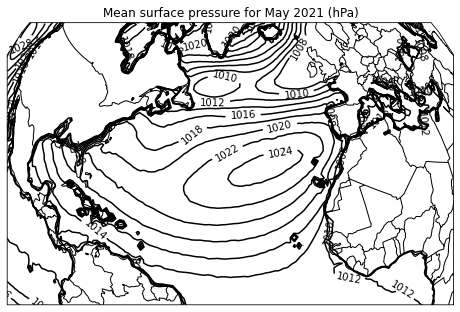

In [6]:
# Select data to plot, and add a "cyclic point" to prevent weird plotting behavior
data      = sp.mean('time')
data, lon = add_cyclic_point(data, coord=data.longitude)
lat       = sp.latitude.values
levels    = np.arange(1008,1032, 2)

# Unfilled contours
fig,ax = plot_setup_orthographic(figsize=(8,7))
cp     = ax.contour(lon, lat, data, 
                    colors='k', levels=levels, transform=ccrs.PlateCarree())
labels = ax.clabel(cp)
ax.set_title('Mean surface pressure for May 2021 (hPa)')
plt.show()

# Filled contour plot with wind vectors

/Users/theo/mambaforge/envs/m1/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1965: RuntimeWarning: invalid value encountered in subtract
  u, v = self.projection.transform_vectors(t, x, y, u, v)


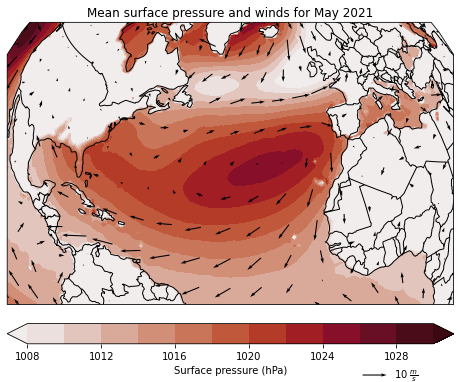

In [8]:
# Select data to plot, and add a "cyclic point" to prevent weird plotting behavior
data      = sp.mean('time')
data, lon = add_cyclic_point(data, coord=data.longitude)
lat       = sp.latitude.values
levels    = np.arange(1008,1032, 2)

# Filled contours
fig,ax = plot_setup_orthographic(figsize=(8,7), plot_range=[-100,20,0,60])
ax.set_title('Mean surface pressure and winds for May 2021')
cp     = ax.contourf(lon, lat, data, cmap='cmo.amp',
                     levels=levels, extend='both', transform=ccrs.PlateCarree())

n = 7     # plot every nth vector
uv10_mean = uv10.mean('time')
u_        = uv10_mean.u10.values
v_        = uv10_mean.v10.values 
qv     = ax.quiver(uv10.longitude.values[::n], 
                   uv10.latitude.values[::n], 
                   u_[::n,::n], 
                   v_[::n,::n],
                  transform=ccrs.PlateCarree())
ax.quiverkey(qv, X=.85, Y=-.25, U=10, label=r'10 $\frac{m}{s}$', labelpos='E')
cb     = fig.colorbar(cp, orientation='horizontal', label=r'Surface pressure (hPa)', pad=.05)
plt.show()

# Create animation
Animation is 3-hourly surface pressure and winds (like previous plot).  
(This is pretty slow; needs to be fixed...)

In [102]:
def get_frame(sp_data, uv_data, idx, label, frame_folder, title=None, display=True):
    '''Function to get single frame for the animation'''
    # Select data to plot, and add a "cyclic point" to prevent weird plotting behavior
    data, lon = add_cyclic_point(sp_data, coord=sp_data.longitude)
    lat       = sp.latitude.values
    levels    = np.arange(1008,1032, 2)

    fig,ax = plot_setup_orthographic(figsize=(8,7), plot_range=[-100,20,0,60])
    ax.set_title(title)
    
    # Filled contours (surface pressure)
    cp     = ax.contourf(lon, lat, data, cmap='cmo.amp',
                         levels=levels, extend='both', transform=ccrs.PlateCarree())
    cb     = fig.colorbar(cp, orientation='horizontal', label=r'Surface pressure (hPa)', pad=.05)
    
    # Wind vector plot
    n = 7     # plot every nth vector (decrease n for more arrows per unit area)
    u_        = uv_data.u10.values # get numpy array of u and v wind data
    v_        = uv_data.v10.values
    qv     = ax.quiver(uv_data.longitude.values[::n], 
                       uv_data.latitude.values[::n], 
                       u_[::n,::n], 
                       v_[::n,::n],
                       transform=ccrs.PlateCarree())
    ax.quiverkey(qv, X=.85, Y=-.25, U=10, label=r'10 $\frac{m}{s}$', labelpos='E')
    if display:
        plt.show()
    else:
        fig.savefig(join(frame_folder, f'{label}_{idx:05d}.png'))
        plt.close(fig)
    return

def get_time_string(t):
    '''Utility function. Given time (dataarray format), get string'''
    hr     = t.dt.hour.values.item()
    da     = t.dt.day.values.item()
    mo     = t.dt.month.values.item()
    ye     = t.time.dt.year.values.item()
    return f'{ye}/{mo:02d}/{da:02d} {hr:02d}:00'

In [ ]:
frame_folder = 'animation-figs'  # folder to store frames for animation
label        = 'uv10-sp-may2021' # prefix for frame filenames

# Loop through time steps to create frames (note: this is slow...)
for i in range(len(uv10.time)):
    uv_data = uv10.isel(time=i)
    sp_data = sp.isel(time=i)
    title   = f'Surface pressure and wind, {get_time_string(uv_data.time)}'
    get_frame(sp_data, uv_data, idx=i, frame_folder=frame_folder, 
              label=label, title=title, display=False)

Use a command like this to make a movie from the frames (enter in terminal):  
```ffmpeg -r 5 -i animation-figs/uv10-sp-may2021_%05d.png -vcodec libx264 -crf 15 -pix_fmt yuv420p animation.mp4```

Note: 
- replace ```animation-figs``` with the name of the folder containing the individual frames. 
- ```-r``` is the frame rate